In [1]:
import os
import pickle as pkl
import pandas as pd
import numpy as np

import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [103]:
# Loading the data from package
#DATA_PATH = "/Users/katsiarynadavydzenka/Documents/PhD_AI/CN-aware-DGE/Python/datasets/"
#counts_df = pd.read_csv(os.path.join(DATA_PATH, "rna_counts_cnv_v2.csv"), index_col=0)
#counts_df = counts_df.T
#metadata = pd.read_csv(os.path.join(DATA_PATH, "metadata_v2.csv"), index_col=0)

In [3]:
# Test real data
DATA_PATH = "/Users/katsiarynadavydzenka/Documents/PhD_AI/CN-aware-DGE/simulations/data/replicates/"
counts_df = pd.read_csv(os.path.join(DATA_PATH, "1_rna_join_100_3000.csv"), index_col=0)
counts_df = counts_df.T
metadata = pd.read_csv(os.path.join(DATA_PATH, "1_metadata_100_3000.csv"), index_col=0)

In [5]:
#Data filtering
#genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
#counts_df = counts_df[genes_to_keep]
counts_df.shape

(200, 3000)

In [41]:
inference = DefaultInference(n_cpus=8)

dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
)

dds.fit_size_factors()
dds.fit_genewise_dispersions()
dds.fit_dispersion_trend()
dds.fit_dispersion_prior()
dds.fit_MAP_dispersions()
dds.fit_LFC()

dds.calculate_cooks()
if dds.refit_cooks:
    # Replace outlier counts
    dds.refit()

# Statistical analysis
stat_res = DeseqStats(dds, 
                      alpha=0.05, 
                      cooks_filter=True, 
                      independent_filter=True)

stat_res.run_wald_test()

if stat_res.cooks_filter:
    stat_res._cooks_filtering()
stat_res.p_values

# p-value adjustment

if stat_res.independent_filter:
    stat_res._independent_filtering()
else:
    stat_res._p_value_adjustment()

stat_res.padj

stat_res.summary()

stat_res.lfc_shrink(coeff="condition_B_vs_A")

#Save results
OUTPUT_PATH = "/Users/katsiarynadavydzenka/Documents/PhD_AI/CN-aware-DGE/Python/results/COAD"
os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist
stat_res.results_df.to_csv(os.path.join(OUTPUT_PATH, "res_CNnaive_all_genes.csv"))

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.65 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 2.02 seconds.

Fitting LFCs...
... done in 0.99 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 787 outlier genes.

Fitting dispersions...
... done in 0.11 seconds.

Fitting MAP dispersions...
... done in 0.10 seconds.

Fitting LFCs...
... done in 0.07 seconds.

Running Wald tests...
... done in 0.60 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition B vs A
             baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1CF      1253.058267       -2.257781  0.439727 -5.134511  2.828784e-07   
A2M      13828.341423       -1.343793  0.269242 -4.991023  6.006035e-07   
A2M-AS1     21.736545       -0.857508  0.359804 -2.383265  1.715984e-02   
A4GALT     345.343006        0.187670  0.373745  0.502134  6.155734e-01   
AAAS      1371.575328        0.657031  0.199061  3.300644  9.646316e-04   
...               ...             ...       ...       ...           ...   
ZXDC      1038.869133        0.637362  0.161727  3.940984  8.114806e-05   
ZYG11B    1152.431628       -0.590640  0.329146 -1.794460  7.273978e-02   
ZYX       6392.103122        1.126300  0.306321  3.676866  2.361173e-04   
ZZEF1     5508.618169       -1.807188  0.224194 -8.060807  7.579220e-16   
ZZZ3      1079.486722        0.657577  0.283643  2.318329  2.043143e-02   

                 padj  
A1CF     2.049155e-0

... done in 1.94 seconds.



In [57]:
#dds.obsm["size_factors"]
#dds.varm["genewise_dispersions"]
#dds.varm["fitted_dispersions"]
#print(
    #f"logres_prior={dds.uns['_squared_logres']}, sigma_prior={dds.uns['prior_disp_var']}"
#)
#dds.varm["MAP_dispersions"]
#dds.varm["dispersions"]
#dds.varm["LFC"]

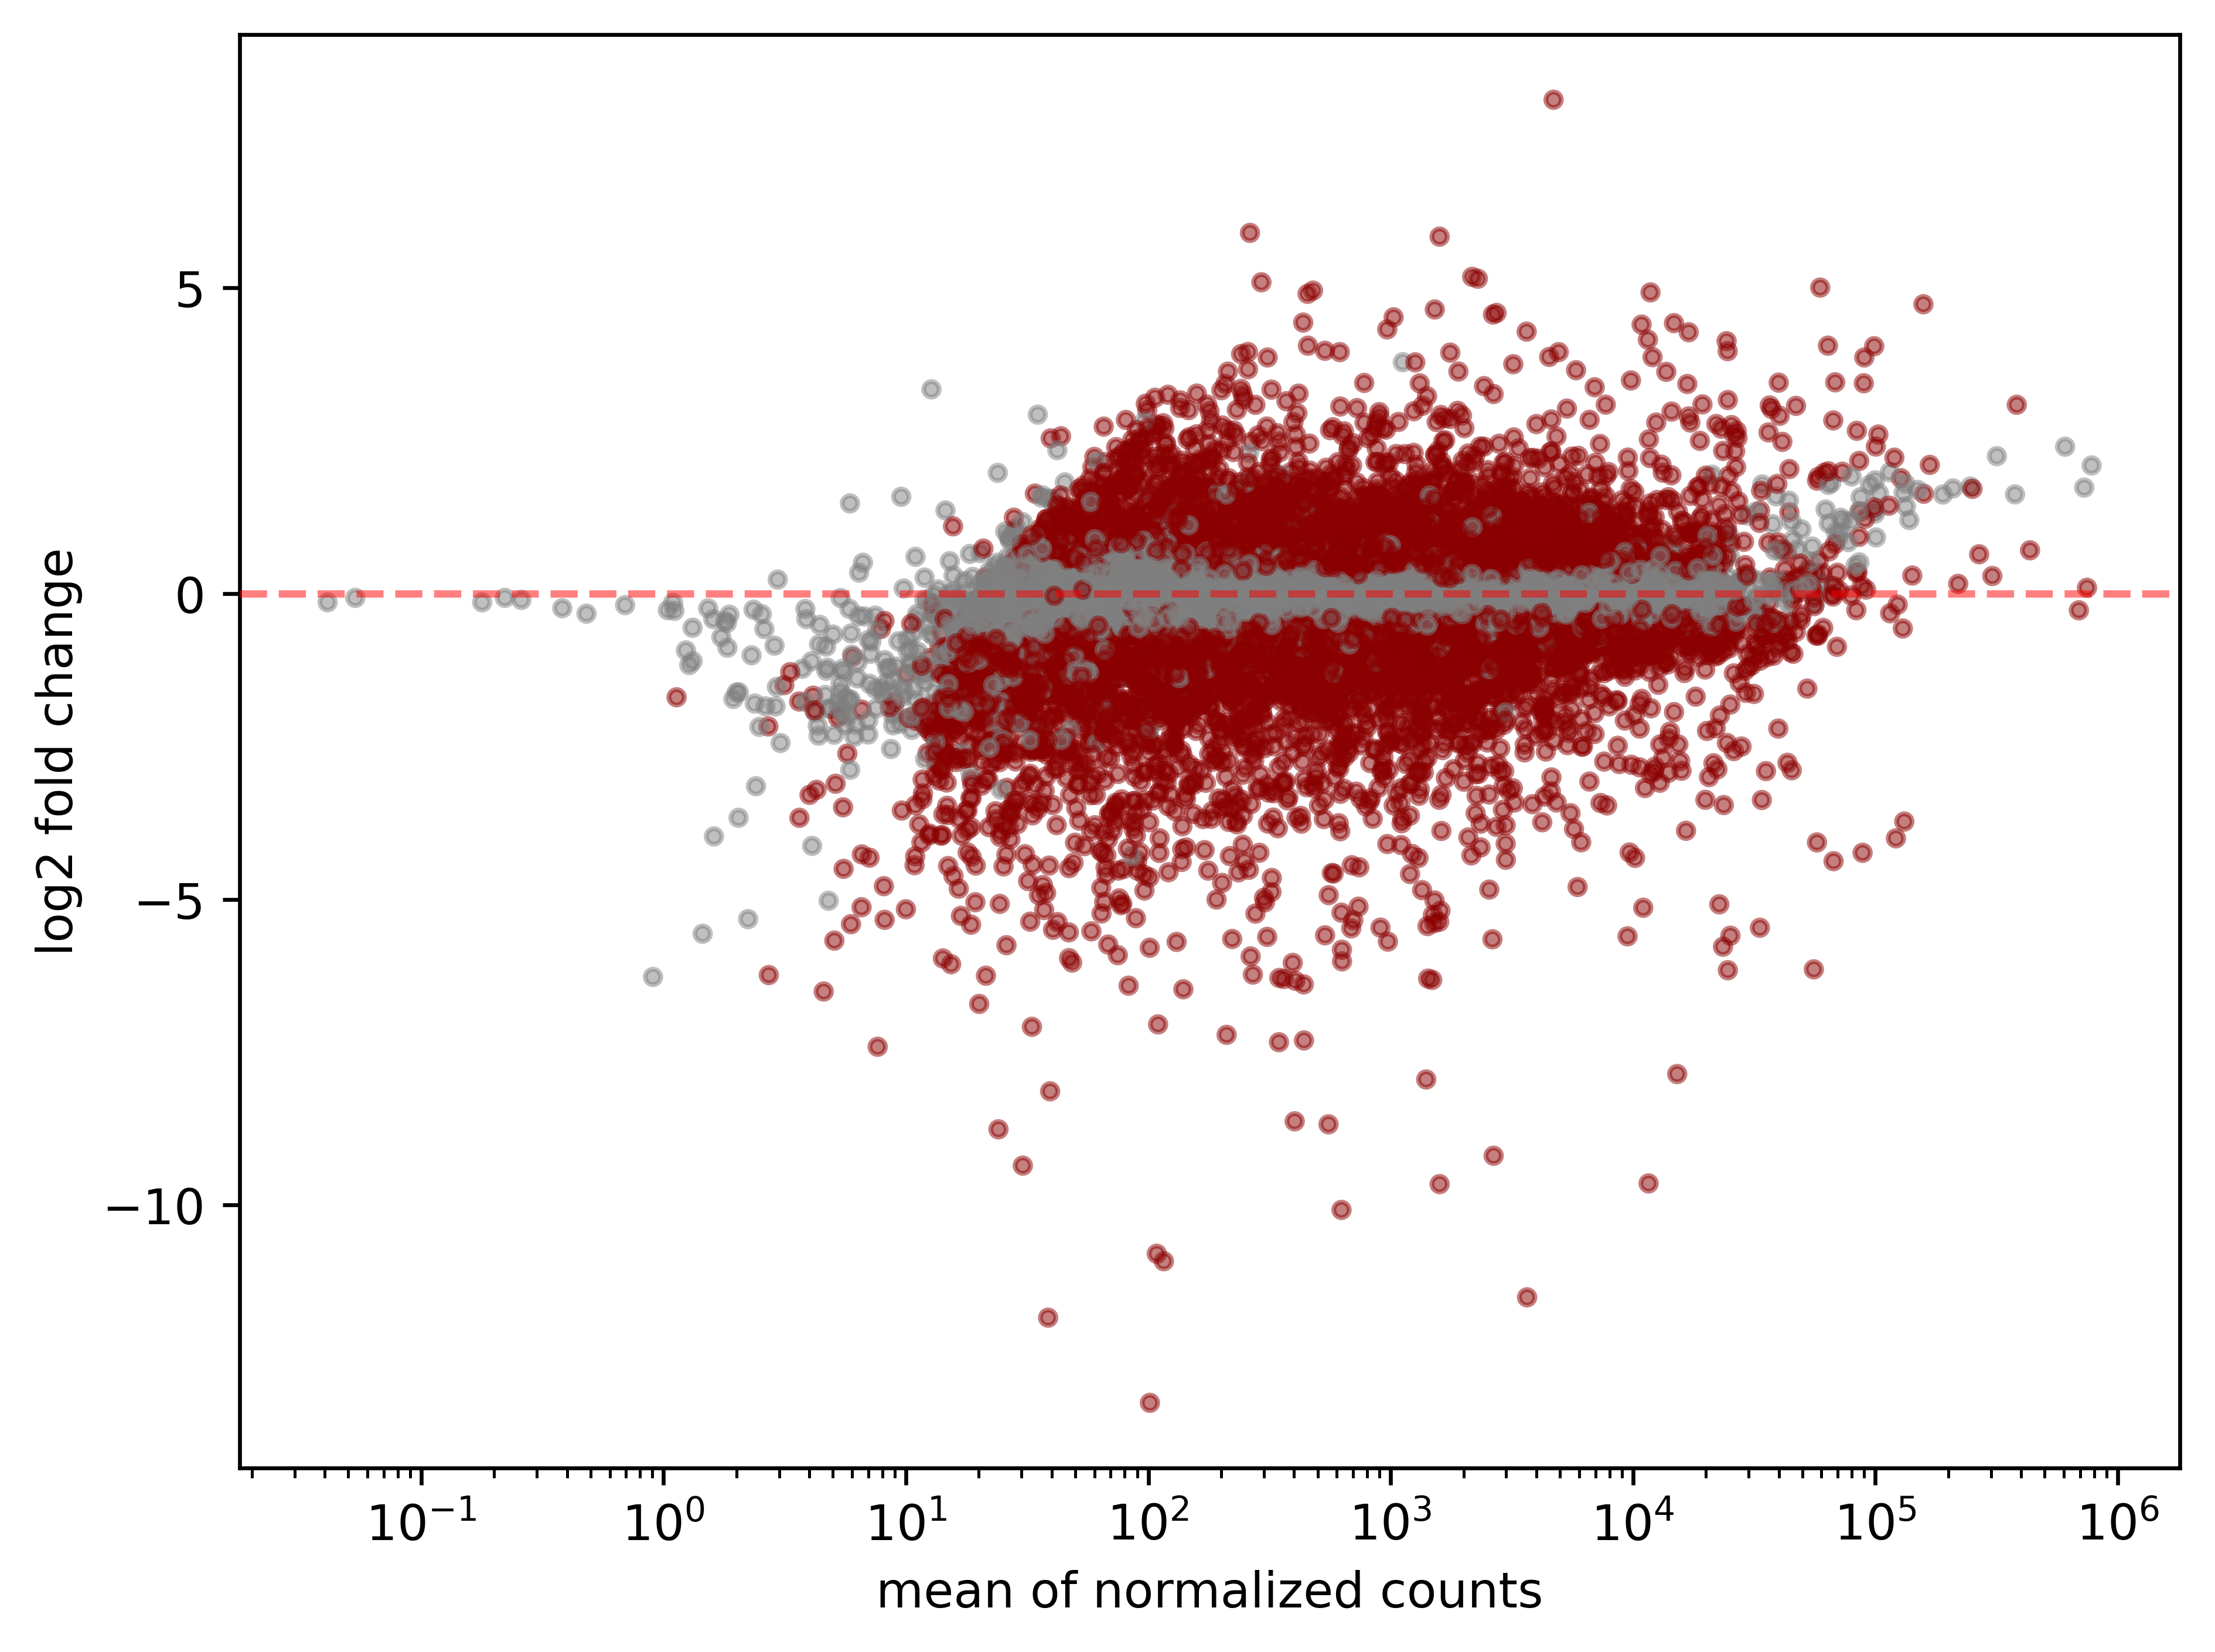

In [35]:
stat_res.plot_MA(s=10)